In [32]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [33]:
#the oracle that flips the output qubit if 
#1. 選的行或列已包含了所有星星 (oracle 1)
#2. control qubit 為 1 的個數為 3 (oracle 2)
#如何使用此 oracle見下面 example


def plus_one(n, c2):
    qc.mct([input_qubits[n], numof1_qubits[0], numof1_qubits[1]], check_qubits2[c2])
    qc.ccx(input_qubits[n], numof1_qubits[1], numof1_qubits[0])
    qc.cx(input_qubits[n], numof1_qubits[1])

def plus_one_r(n, c2):
    qc.cx(input_qubits[n], numof1_qubits[1])
    qc.ccx(input_qubits[n], numof1_qubits[1], numof1_qubits[0])
    qc.mct([input_qubits[n], numof1_qubits[0], numof1_qubits[1]], check_qubits2[c2])
    
    
def oracle(qc, clause_list):


    #Oracle1: 
    i = 0
    for clause in clause_list:
        qc.cx(input_qubits[clause[0]], check_qubits1[i])
        qc.cx(input_qubits[clause[1]], check_qubits1[i])
        qc.ccx(input_qubits[clause[0]], input_qubits[clause[1]], check_qubits1[i])
        #qc.barrier()
        i += 1
    qc.barrier()

    #Oracle2
    #initialize check_qubits2 to 1
    for k in range(5):
        qc.x(check_qubits2[k])
        
    qc.cx(input_qubits[0], numof1_qubits[1])
    #qc.barrier()
    qc.ccx(input_qubits[1], numof1_qubits[1], numof1_qubits[0])
    qc.cx(input_qubits[1], numof1_qubits[1])
    #qc.barrier()
    qc.ccx(input_qubits[2], numof1_qubits[1], numof1_qubits[0])
    qc.cx(input_qubits[2], numof1_qubits[1])
    #qc.barrier()

    for i in range(3,7+1):
        plus_one(i, i-3)
        #qc.barrier()
    qc.barrier()

    #output to target qubit
    check_qubits1list = []
    for i in range(len(clause_list)):
        check_qubits1list.append(check_qubits1[i])

    check_qubits2list = []
    for i in range(5):
        check_qubits2list.append(check_qubits2[i])

    qc.mct(check_qubits1list + [numof1_qubits[0], numof1_qubits[1]] + check_qubits2list, output_qubit[0] )

    qc.barrier()

    #Oracle1(reverse)

    i = 0
    for clause in clause_list:
        qc.cx(input_qubits[clause[0]], check_qubits1[i])
        qc.cx(input_qubits[clause[1]], check_qubits1[i])
        qc.ccx(input_qubits[clause[0]], input_qubits[clause[1]], check_qubits1[i])
        #qc.barrier()
        i += 1
    
    qc.barrier()
    #Oracle2(reverse)
    
    for i in range(7, 3-1, -1):
        plus_one_r(i, i-3)
        #qc.barrier()

    qc.cx(input_qubits[2], numof1_qubits[1])
    qc.ccx(input_qubits[2], numof1_qubits[1], numof1_qubits[0])
    #qc.barrier()
    qc.cx(input_qubits[1], numof1_qubits[1])
    qc.ccx(input_qubits[1], numof1_qubits[1], numof1_qubits[0])
    #qc.barrier()
    qc.cx(input_qubits[0], numof1_qubits[1])
    #qc.barrier()
    
    #turn check_qubits2 back to 0
    for k in range(5):
        qc.x(check_qubits2[k])
        
def diffuser(qc,n):

    for i in range(n):
        qc.h(input_qubits[i])

    for i in range(n):
        qc.x(input_qubits[i])

#    qc.h(0)
    qc.mct(input_qubits[1:4], 0)
    qc.mct(input_qubits[5:8], 4) 
#    qc.h(0)

    for i in range(n):
        qc.x(input_qubits[i])

    for i in range(n):
        qc.h(input_qubits[i])            

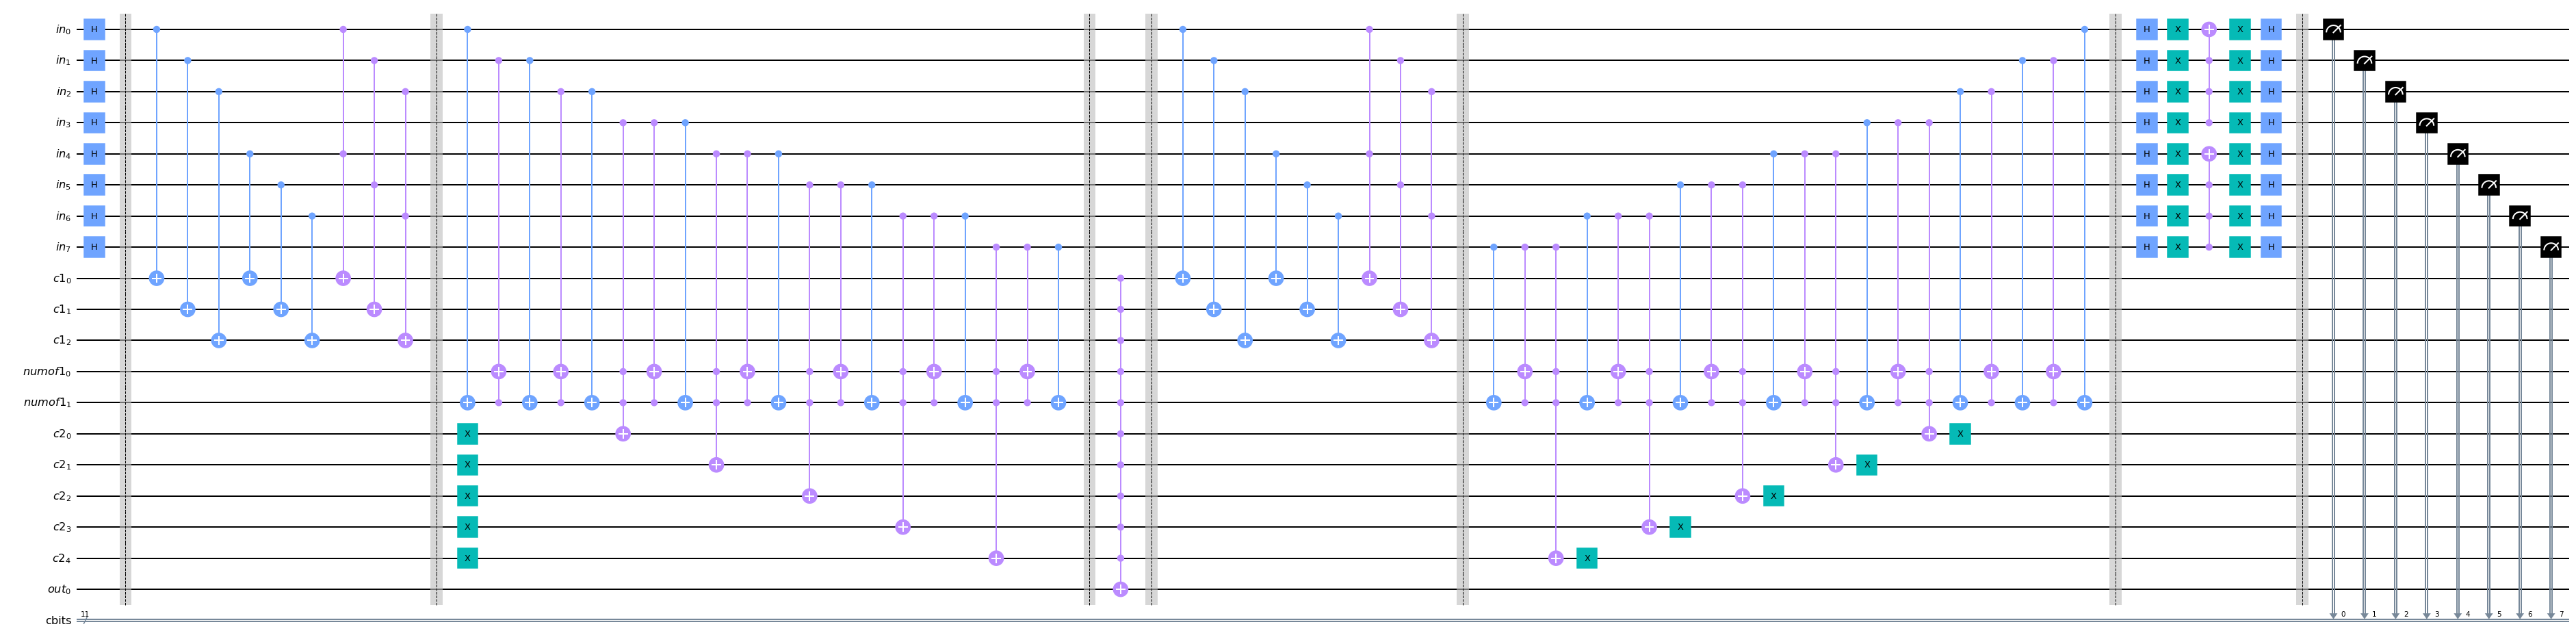

In [34]:
#an example of using this oracle (可以自己改不同數字來測試)
clause_list = [[0,4],[1,5],[2,6]] #0,1,2,3 就是 1,2,3,4列 ，4,5,6,7就是 1,2,3,4行，像是 [1,5]就代表一個星星在第二行第二列的位置
#注: 除了 input qubits 和 output qubits，這個 oracle需要一些 auxiliary qubits，其中 oracle 1 需要用到 check_qubits1 (看有幾個星星就幾個qubits)
#而 oracle 2 需要用到 2(numof1_qubits) + 5(check_qubits2) 個 qubits
#使用這個 oracle 時只要如下5行initialize這些auxiliary qubits，oracle就可正常運作。(名字記得取一樣的) 
input_qubits = QuantumRegister(8, name='in')
check_qubits1 = QuantumRegister(len(clause_list), name='c1')
numof1_qubits = QuantumRegister(2, name = 'numof1')
check_qubits2 = QuantumRegister(5, name = 'c2')
output_qubit = QuantumRegister(1, name = 'out')

#這行以下為測試此oracle是否正確
cbits = ClassicalRegister(8+len(clause_list), name = 'cbits')
qc = QuantumCircuit(input_qubits, check_qubits1, numof1_qubits, check_qubits2, output_qubit, cbits)

for i in range(8):
    qc.h(input_qubits[i])
qc.barrier()

# 假設取第1,2,3列，檢查是否涵蓋所有星星
#qc.x(input_qubits[0])
#qc.x(input_qubits[1])
#qc.x(input_qubits[2])
#qc.x(node_qubits[3])
#qc.barrier()

oracle(qc, clause_list)
qc.barrier()

diffuser(qc,8)
qc.barrier()

#repeat
#oracle(qc, clause_list)
#qc.barrier()

#diffuser(qc,8)
#qc.barrier()

#i=0

#while i < len(clause_list):
#    qc.measure(check_qubits1[i], i)
#    i += 1

#qc.measure(numof1_qubits[0],i)
#i += 1
#qc.measure(numof1_qubits[1],i)
#i += 1

#for j in range(5):
#    qc.measure(check_qubits2[j], i) 
#    i += 1

#qc.measure(output_qubit[0], i)

i=0

while i < 8:
    qc.measure(input_qubits[i], i)
    i += 1

qc.draw(output='mpl', fold=-1)

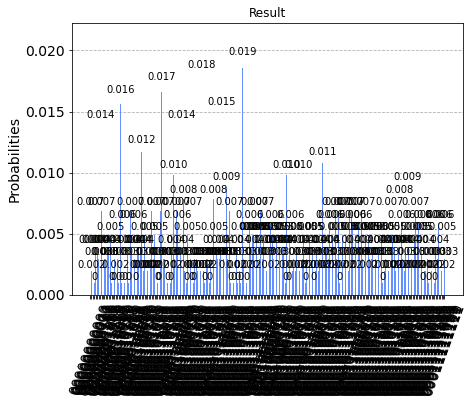

In [41]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(qc, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer, title="Result")

In [42]:
print(answer)

{'00000101000': 2, '00001101100': 1, '00001001111': 2, '00000111000': 1, '00000010011': 2, '00011110001': 2, '00001000110': 1, '00000010111': 1, '00010100010': 1, '00011100100': 4, '00000100001': 1, '00000011000': 6, '00000100011': 4, '00011000100': 4, '00010011110': 3, '00001100111': 1, '00010111011': 2, '00010100111': 3, '00001001110': 2, '00001100000': 4, '00000110111': 3, '00010001010': 4, '00011011010': 4, '00001111000': 5, '00010011000': 2, '00001111001': 7, '00010111000': 3, '00010100000': 5, '00000010100': 3, '00001001100': 3, '00011010101': 2, '00011101111': 4, '00000110010': 1, '00011001111': 3, '00010100101': 2, '00001010100': 1, '00010001001': 4, '00010011101': 3, '00001111100': 3, '00010001000': 5, '00001010111': 1, '00011000111': 2, '00010011100': 1, '00001110110': 4, '00010111111': 3, '00010110101': 2, '00001111110': 3, '00011110100': 1, '00000111110': 7, '00010010000': 1, '00010011010': 3, '00001100110': 7, '00001001011': 1, '00011010110': 3, '00001011011': 8, '00010101

In [43]:
print(answer.most_frequent())

00001110000
